In [ ]:
## Get public Movebank datasets from DataCite

In [1]:
%matplotlib inline

import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
parameters = {
    'q': '*',
    'fq': 'prefix:"10.5441"', # Prefix for Movebank
    'fl': ','.join([ # Fields to include
        'doi',
        'publisher',
        'contributor',
        'title',
        'description',
        'creator',
        'subject',
        'rightsURI',
        'publicationYear',
        'format',
        'descriptionType',
        'relatedIdentifier',
        'created',
        'updated']),
    'rows': 1000,
    'wt': 'csv'
}
results = requests.get('https://search.datacite.org/api', params=parameters)

In [3]:
results.url

'https://search.datacite.org/api?q=%2A&fq=prefix%3A%2210.5441%22&wt=csv&fl=doi%2Cpublisher%2Ccontributor%2Ctitle%2Cdescription%2Ccreator%2Csubject%2CrightsURI%2CpublicationYear%2Cformat%2CdescriptionType%2CrelatedIdentifier%2Ccreated%2Cupdated&rows=1000'

In [4]:
data = pd.read_csv(
    StringIO(results.text),
    delimiter=',',
    encoding='ISO-8859-1',
    dtype=object
)

In [5]:
data.count()["doi"]

503

In [6]:
data.columns.tolist()

['doi',
 'publisher',
 'contributor',
 'title',
 'description',
 'creator',
 'subject',
 'rightsURI',
 'publicationYear',
 'format',
 'descriptionType',
 'relatedIdentifier',
 'created',
 'updated']

In [7]:
field_of_interest = "publicationYear"

In [8]:
field_of_interest_groupby = data.groupby([field_of_interest]).count()["doi"].reset_index()

In [9]:
field_of_interest_groupby

,publicationYear,doi
0,2008,1
1,2009,2
2,2011,5
3,2012,15
4,2013,19
5,2014,150
6,2015,155
7,2016,146


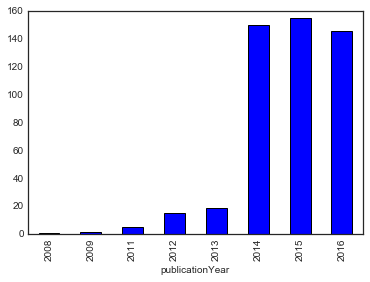

In [11]:
field_of_interest_groupby.plot(kind='bar', x=field_of_interest, legend=False)